In [91]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats


In [92]:
df = pd.read_csv("Final.csv")
df.head()

,CUSTOMER_ORDER_ID,SALES_ORG,DISTRIBUTION_CHANNEL,DIVISION,RELEASED_CREDIT_VALUE,PURCHASE_ORDER_TYPE,COMPANY_CODE,ORDER_CREATION_DATE,ORDER_CREATION_TIME,CREDIT_CONTROL_AREA,SOLD_TO_PARTY,ORDER_AMOUNT,REQUESTED_DELIVERY_DATE,ORDER_CURRENCY,CREDIT_STATUS,CUSTOMER_NUMBER
0,946851639,3537,United States of America,South-Region,"0,00",1000,3220,20220101,43012,SR02,756141537,"954,61",20220113,EUR,NaN,12311807
1,963432061,3449,Martinique,South-Region,"0,00",1000,3220,20220101,43114,NR03,798847812,"787,36",20220111,EUR,NaN,12311807
2,971991639,3238,Moldova,South-Region,"82342,02",I200,3260,20220101,110019,NR01,960984659,"67493,46",20220112,EUR,93.0,12118758
3,754349803,3911,United Arab Emirates,South-Region,"1471,24",N000,3290,20220101,153013,SR02,925857642,"1405,54",20220106,EUR,93.0,1210499770
4,930253442,2381,Greece,South-Region,"0,00",N000,3290,20220101,160020,SR01,947942786,"0,00",20220106,EUR,64.0,1210351400


In [93]:
df.fillna("NaN", inplace=True)
df.isnull().sum()

CUSTOMER_ORDER_ID          0
SALES_ORG                  0
DISTRIBUTION_CHANNEL       0
DIVISION                   0
RELEASED_CREDIT_VALUE      0
PURCHASE_ORDER_TYPE        0
COMPANY_CODE               0
ORDER_CREATION_DATE        0
ORDER_CREATION_TIME        0
CREDIT_CONTROL_AREA        0
SOLD_TO_PARTY              0
ORDER_AMOUNT               0
REQUESTED_DELIVERY_DATE    0
ORDER_CURRENCY             0
CREDIT_STATUS              0
CUSTOMER_NUMBER            0
dtype: int64

In [94]:
df["ORDER_CREATION_DATE"] = pd.to_datetime(df["ORDER_CREATION_DATE"], format="%Y%m%d")
df["REQUESTED_DELIVERY_DATE"] = pd.to_datetime(df["REQUESTED_DELIVERY_DATE"], format="%Y%m%d")
df.drop(df[(df["ORDER_CREATION_DATE"] > df["REQUESTED_DELIVERY_DATE"])].index, inplace=True)
len(df[df["ORDER_CREATION_DATE"] > df["REQUESTED_DELIVERY_DATE"]])


0

In [95]:
df["ORDER_AMOUNT"] = df["ORDER_AMOUNT"].str.replace("-", "")
df["ORDER_AMOUNT"] = df["ORDER_AMOUNT"].str.replace(",", ".")
df['RELEASED_CREDIT_VALUE'] = df["RELEASED_CREDIT_VALUE"].str.replace("-", "")
df["RELEASED_CREDIT_VALUE"] = df["RELEASED_CREDIT_VALUE"].str.replace(",", ".")


In [96]:
len(df[df["ORDER_CREATION_DATE"] == df["REQUESTED_DELIVERY_DATE"]])

100437

In [97]:
df["ORDER_CURRENCY"] = df["ORDER_CURRENCY"].replace("HU1", "HUF")
import requests
apikey = "347adc49463e4adfafd55bba3192ed32"
url = f"https://openexchangerates.org/api/latest.json?app_id={apikey}"
response = requests.get(url)
data = response.json()
exchange_rates = data["rates"]


def convert_to_usd(row):
    amount = row['ORDER_AMOUNT']
    currency = row['ORDER_CURRENCY']
    if currency != 'USD':
        return float(amount) / exchange_rates.get(currency, 1)
    return amount


df['amount_in_usd'] = df.apply(convert_to_usd, axis=1)

In [98]:
df["UNIQUE_CUST_ID"] = df["CUSTOMER_NUMBER"].astype(str) + df["COMPANY_CODE"].astype(str)

In [99]:
df.nunique()

CUSTOMER_ORDER_ID          1072429
SALES_ORG                     2411
DISTRIBUTION_CHANNEL           243
DIVISION                         2
RELEASED_CREDIT_VALUE        47462
PURCHASE_ORDER_TYPE            351
COMPANY_CODE                    28
ORDER_CREATION_DATE            152
ORDER_CREATION_TIME          80434
CREDIT_CONTROL_AREA              8
SOLD_TO_PARTY              1072376
ORDER_AMOUNT                233719
REQUESTED_DELIVERY_DATE        319
ORDER_CURRENCY                  20
CREDIT_STATUS                    4
CUSTOMER_NUMBER               6692
amount_in_usd               354069
UNIQUE_CUST_ID                6699
dtype: int64

In [100]:
df.dtypes

CUSTOMER_ORDER_ID                   int64
SALES_ORG                           int64
DISTRIBUTION_CHANNEL               object
DIVISION                           object
RELEASED_CREDIT_VALUE              object
PURCHASE_ORDER_TYPE                object
COMPANY_CODE                        int64
ORDER_CREATION_DATE        datetime64[ns]
ORDER_CREATION_TIME                 int64
CREDIT_CONTROL_AREA                object
SOLD_TO_PARTY                       int64
ORDER_AMOUNT                       object
REQUESTED_DELIVERY_DATE    datetime64[ns]
ORDER_CURRENCY                     object
CREDIT_STATUS                      object
CUSTOMER_NUMBER                     int64
amount_in_usd                      object
UNIQUE_CUST_ID                     object
dtype: object

In [101]:
df['RELEASED_CREDIT_VALUE'] = df['RELEASED_CREDIT_VALUE'].astype(float)
df['ORDER_AMOUNT'] = df['ORDER_AMOUNT'].astype(float)


df['DISTRIBUTION_CHANNEL'] = df['DISTRIBUTION_CHANNEL'].astype(str)
df['DIVISION'] = df['DIVISION'].astype(str)
df['PURCHASE_ORDER_TYPE'] = df['PURCHASE_ORDER_TYPE'].astype(str)
df['ORDER_CURRENCY'] = df['ORDER_CURRENCY'].astype(str)
df['CREDIT_CONTROL_AREA'] = df['CREDIT_CONTROL_AREA'].astype(str)
df['UNIQUE_CUST_ID'] = df['UNIQUE_CUST_ID'].astype(str)
df['CREDIT_STATUS'] = df['CREDIT_STATUS'].astype(str)


In [102]:
df.drop('ORDER_AMOUNT',axis=1,inplace=True)

In [103]:
Q1 = df.amount_in_usd.astype({'amount_in_usd': 'float64'}).quantile(0.25)
Q3 = df.amount_in_usd.astype({'amount_in_usd': 'float64'}).quantile(0.75)
IQR = Q3-Q1
lb = (Q1-2.2*IQR)
ub = (Q3+2.2*IQR)

print(str(lb)+" "+str(ub))
mean_replace = np.mean(df[~((df.amount_in_usd.astype({'amount_in_usd': 'float64'}) < lb) | (df.amount_in_usd.astype({'amount_in_usd': 'float64'}) > ub))]['amount_in_usd'].astype({'amount_in_usd': 'float64'}))
print(str(mean_replace))
df['amount_in_usd'] = df['amount_in_usd'].astype({'amount_in_usd': 'float64'})
df['amount_in_usd'].loc[(df['amount_in_usd'] < lb) | (df['amount_in_usd'] > ub)]=mean_replace

-1561.7979011465588 2304.7504320382595
393.75089447878037


/tmp/ipykernel_12408/1488811332.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount_in_usd'].loc[(df['amount_in_usd'] < lb) | (df['amount_in_usd'] > ub)]=mean_replace


In [104]:
df['RELEASED_CREDIT_VALUE_LOG'] = np.where(df['RELEASED_CREDIT_VALUE'] > 0, np.log(df['RELEASED_CREDIT_VALUE']), df['RELEASED_CREDIT_VALUE'])
df['amount_in_usd_log'] = np.where(df['amount_in_usd'] > 0, np.log(df['amount_in_usd']), df['amount_in_usd'])

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [105]:
df.columns

Index(['CUSTOMER_ORDER_ID', 'SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION',
       'RELEASED_CREDIT_VALUE', 'PURCHASE_ORDER_TYPE', 'COMPANY_CODE',
       'ORDER_CREATION_DATE', 'ORDER_CREATION_TIME', 'CREDIT_CONTROL_AREA',
       'SOLD_TO_PARTY', 'REQUESTED_DELIVERY_DATE', 'ORDER_CURRENCY',
       'CREDIT_STATUS', 'CUSTOMER_NUMBER', 'amount_in_usd', 'UNIQUE_CUST_ID',
       'RELEASED_CREDIT_VALUE_LOG', 'amount_in_usd_log'],
      dtype='object')

In [106]:
df['EXPECTED_DELIVERY_TIME'] = (df['REQUESTED_DELIVERY_DATE'] - df['ORDER_CREATION_DATE']).dt.days

In [107]:
small_constant = 1
transformed_data = df['RELEASED_CREDIT_VALUE'] + small_constant
transformed_data, best_lambda = stats.boxcox(transformed_data)
df['RELEASED_CREDIT_VALUE_BOXCOX'] = transformed_data
transformed_data = df['amount_in_usd'] + small_constant
transformed_data, best_lambda = stats.boxcox(transformed_data)
df['amount_in_usd_BOXCOX'] = transformed_data
transformed_data = df['EXPECTED_DELIVERY_TIME'] + small_constant
transformed_data, best_lambda = stats.boxcox(transformed_data)
df['EXPECTED_DELIVERY_TIME_BOXCOX'] = transformed_data


In [108]:
df.head()

,CUSTOMER_ORDER_ID,SALES_ORG,DISTRIBUTION_CHANNEL,DIVISION,RELEASED_CREDIT_VALUE,PURCHASE_ORDER_TYPE,COMPANY_CODE,ORDER_CREATION_DATE,ORDER_CREATION_TIME,CREDIT_CONTROL_AREA,...,CREDIT_STATUS,CUSTOMER_NUMBER,amount_in_usd,UNIQUE_CUST_ID,RELEASED_CREDIT_VALUE_LOG,amount_in_usd_log,EXPECTED_DELIVERY_TIME,RELEASED_CREDIT_VALUE_BOXCOX,amount_in_usd_BOXCOX,EXPECTED_DELIVERY_TIME_BOXCOX
0,946851639,3537,United States of America,South-Region,0.00,1000,3220,2022-01-01,43012,SR02,...,NaN,12311807,1019.957668,123118073220,0.000000,6.927516,12,0.000000,18.462142,3.162363
1,963432061,3449,Martinique,South-Region,0.00,1000,3220,2022-01-01,43114,NR03,...,NaN,12311807,841.258597,123118073220,0.000000,6.734899,10,0.000000,17.413346,2.915148
2,971991639,3238,Moldova,South-Region,82342.02,I200,3260,2022-01-01,110019,NR01,...,93.0,12118758,393.750894,121187583260,11.318637,5.975718,11,0.481586,13.736924,3.043098
3,754349803,3911,United Arab Emirates,South-Region,1471.24,N000,3290,2022-01-01,153013,SR02,...,93.0,1210499770,1501.756006,12104997703290,7.293861,7.314390,5,0.481586,20.726833,2.070990
4,930253442,2381,Greece,South-Region,0.00,N000,3290,2022-01-01,160020,SR01,...,64.0,1210351400,0.000000,12103514003290,0.000000,0.000000,5,0.000000,0.000000,2.070990


In [109]:
df.dtypes

CUSTOMER_ORDER_ID                         int64
SALES_ORG                                 int64
DISTRIBUTION_CHANNEL                     object
DIVISION                                 object
RELEASED_CREDIT_VALUE                   float64
PURCHASE_ORDER_TYPE                      object
COMPANY_CODE                              int64
ORDER_CREATION_DATE              datetime64[ns]
ORDER_CREATION_TIME                       int64
CREDIT_CONTROL_AREA                      object
SOLD_TO_PARTY                             int64
REQUESTED_DELIVERY_DATE          datetime64[ns]
ORDER_CURRENCY                           object
CREDIT_STATUS                            object
CUSTOMER_NUMBER                           int64
amount_in_usd                           float64
UNIQUE_CUST_ID                           object
RELEASED_CREDIT_VALUE_LOG               float64
amount_in_usd_log                       float64
EXPECTED_DELIVERY_TIME                    int64
RELEASED_CREDIT_VALUE_BOXCOX            

In [110]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION', 'PURCHASE_ORDER_TYPE', 'CREDIT_CONTROL_AREA', 'CREDIT_STATUS']
df_encoded = df
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [111]:
def difference_in_days(melt, lags, ffday, customer_id_col, create_date_col, net_amount_col):
    for i in range(ffday, lags+1):
        melt['Last-'+str(i)+'day_Sales'] = melt.groupby([customer_id_col])[net_amount_col].shift(i)

    melt = melt.reset_index(drop = True)

    for i in range(ffday, lags+1):
        melt['Last-'+str(i)+'day_Diff']  = melt.groupby([customer_id_col])['Last-'+str(i)+'day_Sales'].diff()
    melt = melt.fillna(0)
    return melt

df= difference_in_days(df,7,1,'CUSTOMER_NUMBER','ORDER_CREATION_DATE','amount_in_usd')

In [112]:
df['Last-1day_Sales_log'] = np.where(df['Last-1day_Sales'] > 0, np.log(df['Last-1day_Sales']), df['Last-1day_Sales'])
df['Last-2day_Sales_log'] = np.where(df['Last-2day_Sales'] > 0, np.log(df['Last-2day_Sales']), df['Last-2day_Sales'])
df['Last-3day_Sales_log'] = np.where(df['Last-3day_Sales'] > 0, np.log(df['Last-3day_Sales']), df['Last-3day_Sales'])
df['Last-4day_Sales_log'] = np.where(df['Last-4day_Sales'] > 0, np.log(df['Last-4day_Sales']), df['Last-4day_Sales'])
df['Last-5day_Sales_log'] = np.where(df['Last-5day_Sales'] > 0, np.log(df['Last-5day_Sales']), df['Last-5day_Sales'])
df['Last-6day_Sales_log'] = np.where(df['Last-6day_Sales'] > 0, np.log(df['Last-6day_Sales']), df['Last-6day_Sales'])
df['Last-7day_Sales_log'] = np.where(df['Last-7day_Sales'] > 0, np.log(df['Last-7day_Sales']), df['Last-7day_Sales'])




/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs

In [113]:
df.columns

Index(['CUSTOMER_ORDER_ID', 'SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION',
       'RELEASED_CREDIT_VALUE', 'PURCHASE_ORDER_TYPE', 'COMPANY_CODE',
       'ORDER_CREATION_DATE', 'ORDER_CREATION_TIME', 'CREDIT_CONTROL_AREA',
       'SOLD_TO_PARTY', 'REQUESTED_DELIVERY_DATE', 'ORDER_CURRENCY',
       'CREDIT_STATUS', 'CUSTOMER_NUMBER', 'amount_in_usd', 'UNIQUE_CUST_ID',
       'RELEASED_CREDIT_VALUE_LOG', 'amount_in_usd_log',
       'EXPECTED_DELIVERY_TIME', 'RELEASED_CREDIT_VALUE_BOXCOX',
       'amount_in_usd_BOXCOX', 'EXPECTED_DELIVERY_TIME_BOXCOX',
       'Last-1day_Sales', 'Last-2day_Sales', 'Last-3day_Sales',
       'Last-4day_Sales', 'Last-5day_Sales', 'Last-6day_Sales',
       'Last-7day_Sales', 'Last-1day_Diff', 'Last-2day_Diff', 'Last-3day_Diff',
       'Last-4day_Diff', 'Last-5day_Diff', 'Last-6day_Diff', 'Last-7day_Diff',
       'Last-1day_Sales_log', 'Last-2day_Sales_log', 'Last-3day_Sales_log',
       'Last-4day_Sales_log', 'Last-5day_Sales_log', 'Last-6day_Sales_log',
    

/tmp/ipykernel_12408/1401257394.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='coolwarm',annot=False)


<Axes: >

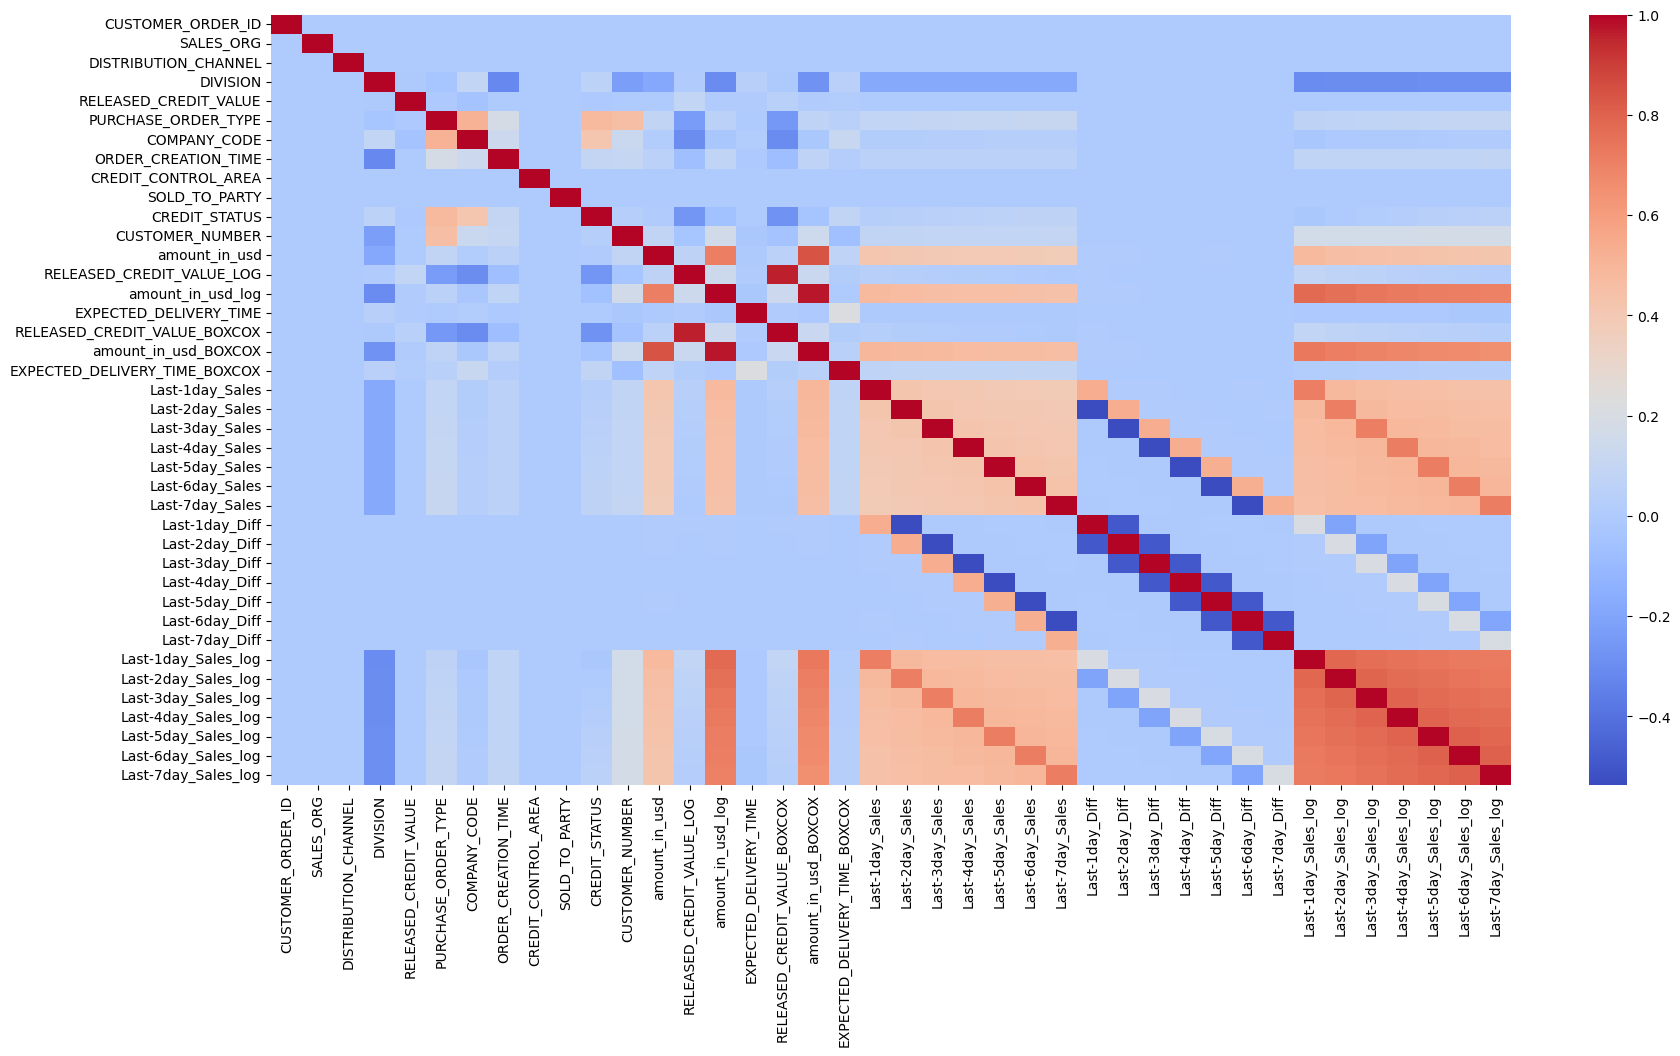

In [114]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),cmap='coolwarm',annot=False)

In [115]:
X=df[['RELEASED_CREDIT_VALUE_LOG','EXPECTED_DELIVERY_TIME','SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION', 'PURCHASE_ORDER_TYPE', 'CREDIT_CONTROL_AREA', 'CREDIT_STATUS','Last-1day_Sales_log','Last-2day_Sales_log','Last-3day_Sales_log','Last-4day_Sales_log','Last-5day_Sales_log','Last-6day_Sales_log','Last-7day_Sales_log']]
y = df['amount_in_usd_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

Mean Squared Error: 2.0399115290989487
R-squared Score: 0.7002583425345821


In [118]:
model = xgb.XGBRegressor()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Train - R-squared Score:", r2_train)
print("Train - Mean Squared Error:", mse_train)
print("Test - R-squared Score:", r2_test)
print("Test - Mean Squared Error:", mse_test)


Mean Squared Error: 1.3533106795684224
R-squared Score: 0.80047758643441


In [119]:
df.columns

Index(['CUSTOMER_ORDER_ID', 'SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION',
       'RELEASED_CREDIT_VALUE', 'PURCHASE_ORDER_TYPE', 'COMPANY_CODE',
       'ORDER_CREATION_DATE', 'ORDER_CREATION_TIME', 'CREDIT_CONTROL_AREA',
       'SOLD_TO_PARTY', 'REQUESTED_DELIVERY_DATE', 'ORDER_CURRENCY',
       'CREDIT_STATUS', 'CUSTOMER_NUMBER', 'amount_in_usd', 'UNIQUE_CUST_ID',
       'RELEASED_CREDIT_VALUE_LOG', 'amount_in_usd_log',
       'EXPECTED_DELIVERY_TIME', 'RELEASED_CREDIT_VALUE_BOXCOX',
       'amount_in_usd_BOXCOX', 'EXPECTED_DELIVERY_TIME_BOXCOX',
       'Last-1day_Sales', 'Last-2day_Sales', 'Last-3day_Sales',
       'Last-4day_Sales', 'Last-5day_Sales', 'Last-6day_Sales',
       'Last-7day_Sales', 'Last-1day_Diff', 'Last-2day_Diff', 'Last-3day_Diff',
       'Last-4day_Diff', 'Last-5day_Diff', 'Last-6day_Diff', 'Last-7day_Diff',
       'Last-1day_Sales_log', 'Last-2day_Sales_log', 'Last-3day_Sales_log',
       'Last-4day_Sales_log', 'Last-5day_Sales_log', 'Last-6day_Sales_log',
    

order amount of upcoming n days for a given customer for a given date
time series prediction
order creation date and unique customer id( indexes used to train)
can calculate total sum of amount of orders for a given date
    calculate total sum of amount of orders for a given customer for a given date